In [45]:
#pip install altair
#pip install seaborn
#pip install sklearn
#pip install imblearn


In [46]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE, ADASYN

plt.rcParams.update({'figure.max_open_warning': 0})

In [47]:
"""
This group of formulas are used for model evaluation
They output the classification report, confusion matrix, ROC curve and ROC-AUC score

Example of use:

classification_report, cmplot, roc_curve, roc_score = scores('Random Forrest', rs_rf3, x_test, y_test )
roc_curve

roc_curve need to be specifically called to display
"""


# Following function plots roc curve for the model.   Input MODEL, TEST DATA and string (name of model with parameters)

import altair as alt
def plot_roc_curve(MODEL, TEST_DATA, t_test, string):
    t_prob = MODEL.predict_proba(TEST_DATA)
    fpr, tpr, _ = metrics.roc_curve(t_test, t_prob[:,1])
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
    main = "ROC Curve of " + string      
    base = alt.Chart(df, 
                 title=main
                ).properties(width=300)
    roc_curve = base.mark_line(point=True).encode(
    alt.X('fpr', title='False Positive Rate (FPR)',  sort=None),
    alt.Y('tpr', title='True Positive Rate (TPR) (a.k.a Recall)'),)
    roc_rule = base.mark_line(color='green').encode(
    x='fpr',
    y='fpr',
    size=alt.value(2)
    )
    return((roc_curve + roc_rule))

# plotting confusion matrix

def plot_confusion_matrix(Targets, Predictions, MODEL_NAME):    
    #create the confusion matrix
    cm = metrics.confusion_matrix(Targets, Predictions)
    #visualise the confusion matrix
    df_cm = pd.DataFrame(cm, ['No','Fraud'], ['No','Fraud'])
    plt.figure(figsize = (5,4))
    cmplot = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", cbar=False)
    cmplot.set_title('Confusion Matrix of ' + MODEL_NAME)
    cmplot.set_ylabel('Actual')
    cmplot.set_xlabel('Prediction')
    sns.reset_orig()
    #show classification report also
    classification_report = metrics.classification_report(Targets, Predictions, zero_division = 0)
    print(classification_report)
    return(cmplot.figure, classification_report)

def scores(MODEL_NAME, MODEL, TEST_DATA, TEST_TARGET):
    Targets = TEST_TARGET
    Predictions = MODEL.predict(TEST_DATA)
    cmplot, classification_report = plot_confusion_matrix(Targets, Predictions, MODEL_NAME)
    roc_curve = plot_roc_curve(MODEL, TEST_DATA, TEST_TARGET, MODEL_NAME)
    roc_score = roc_auc_score(Targets, MODEL.predict_proba(TEST_DATA)[:, 1])
    print("ROC-AUC score is: " + str(np.round(roc_score, decimals = 4)))
    return(classification_report, cmplot, roc_curve, roc_score)

In [48]:
#show all columns to inspect the columns
pd.set_option('display.max_columns', None)

In [49]:
df = pd.read_csv('data\case_study_exercise.csv')

# Data Exploration

In [50]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17/10/2014,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,25/01/2015,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27/06/2006,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,21/01/2015,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,6/09/2000,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,22/02/2015,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25/05/1990,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,10/01/2015,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/06/2014,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,17/02/2015,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [51]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

In [52]:
missing_stats = []

for col in df.columns:
    missing_stats.append((col, 
                          df[col].nunique(), 
                          df[col].isnull().sum() * 100 / df.shape[0], 
                          df[col].value_counts(normalize=True, dropna=False).values[0], 
                          df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'largest_value_perc', 'type'])
stats_df

,feature,unique_values,percent_missing,largest_value_perc,type
0,months_as_customer,391,0.0,0.008,int64
1,age,46,0.0,0.049,int64
2,policy_number,1000,0.0,0.001,int64
3,policy_bind_date,951,0.0,0.003,object
4,policy_state,3,0.0,0.352,object
5,policy_csl,3,0.0,0.351,object
6,policy_deductable,3,0.0,0.351,int64
7,policy_annual_premium,991,0.0,0.002,float64
8,umbrella_limit,11,0.0,0.798,int64
9,insured_zip,995,0.0,0.002,int64


In [53]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


## Preprocessing the data:

### Features to remove:

- policy_number 
    - as it is an identifyer only
- incident_location 
    -  as each piece of data have an unique location.  It is not useable as a categorical information in current state.   To make it useable, it would need to have to be spatially analysed.   This is beyond the scope given the resources of this project.
- insured_zip
    - this is removed as it is an identifier for where the policy holder live.  While it doesn't hold enough value in itself.  However if linked to the demographics of the area, then it might be a better feature.  E.g. To see if how well off the suburb and its relation to the data.  It is beyond the scope of this project.

### Features to re-engineer
- new feature 'policy_length' = number of days from 'policy_bind_date' to 'incident_date' 
Makes more sense to use the dates rather than on their own, looking at the amount of time between the policy is taken out and the incident time.
Those features are removed since the information is contained within 

- policy_csl have been converted into two components, lower and upper, those numbers may have information contained that helps the analysis.


### Features to clean:

'?' was used to indicate as a third category from 'yes and 'no' in some of the columns.  'unknown' is imputed in its place as '?' may cause problems.
- collision_type
- police_report_available
- property_damage

### Feature to convert to ordinal
- incident_severity
    - inherit ranking in the data.   Set to ordinal.
- policy_csl 
    - policy_csl have 3 categories that have inherit ordinal value to them.  Hence converted.
- insured_education_level
    - education level have inherit ranking, converted to ordinal

### Features to remove impossible values
- umbrealla_limit
    - umbrella limit cannot be zero. Any negative values is probably an error  
- capital-loss
    - capital loss is mostly represented as negative


### Next steps to expand

- Analyse the location of the accident, road conditions, traffic conditions, etc.
- Analyse the location of accident
    - How far from the place of resident


In [54]:
#drop policy number and incident_location as it is an index

df.drop(['policy_number', 'incident_location', 'insured_zip'], axis = 1, inplace = True)


In [55]:
# adding policy length as an additional feature and removing the two columns that generated it
df['policy_length'] = pd.to_datetime(df.incident_date) - pd.to_datetime(df.policy_bind_date)
df['policy_length'] = df['policy_length'].dt.days

df.drop(['incident_date', 'policy_bind_date'], axis = 1, inplace = True)

In [56]:
#replace "?" with unknown 
df['collision_type'] = df['collision_type'].replace("?", "unknown")
df['police_report_available'] = df['police_report_available'].replace("?", "unknown")
df['property_damage'] = df['property_damage'].replace("?", "unknown")

In [57]:
#incident_severity can be seen as ordinal
#code them in order of severity 

df['incident_severity'] = df['incident_severity'].map({"Trivial Damage":1,
                                                       "Minor Damage":2,
                                                       "Major Damage":3,
                                                       "Total Loss":4
                                                      }).astype("int32")
df.incident_severity.value_counts()

2    354
4    280
3    276
1     90
Name: incident_severity, dtype: int64

In [58]:
#umbrella limit cannot be zero. Any negative values is probably an error  

df[df['umbrella_limit'] <0]

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,policy_length
290,284,42,OH,100/300,500,1338.54,-1000000,MALE,Associate,machine-op-inspct,kayaking,wife,0,0,Single Vehicle Collision,Side Collision,3,Ambulance,NC,Arlington,13,1,YES,0,1,unknown,94160,8560,17120,68480,Chevrolet,Malibu,1996,N,7239


In [59]:
#converting all umbrella limit numbers to positive

df['umbrella_limit'] = df['umbrella_limit'].abs()

In [60]:
df['policy_csl'].unique()

array(['250/500', '100/300', '500/1000'], dtype=object)

In [61]:
#splitting policy csl into its lower and upper component  
df['policy_csl_lower'] = df['policy_csl'].str.extract("^(.+?)/").astype('int')
df['policy_csl_upper'] = df['policy_csl'].str.extract("\/(.*)").astype('int')
#creating a ratio between the numbers as an extra feature
#df['policy_csl_ratio'] = df['policy_csl_lower'] /df['policy_csl_upper']
#actually this doesn't make much sense as the information is still captured

#Change policy csl to ordinal
df['policy_csl'] = df['policy_csl'].map({'100/300':1,
                                            '250/500':2,
                                            '500/1000':3
                                            }).astype("int32")
df[['policy_csl','policy_csl_lower','policy_csl_upper']].head()

,policy_csl,policy_csl_lower,policy_csl_upper
0,2,250,500
1,2,250,500
2,1,100,300
3,2,250,500
4,3,500,1000


In [62]:
df['insured_education_level'].value_counts()

JD             161
High School    160
Associate      145
MD             144
Masters        143
PhD            125
College        122
Name: insured_education_level, dtype: int64

In [63]:
#Change insured_education_level to ordinal
"""
Assuming JD measn Juris Doctor and MD means Medical doctor, we put them at same level as PhD.   
'JD': 5,  
'MD': 5,  
'PhD':5,  
'Masters':4,  
'College': 3,  
'Associate': 2,  
'High School': 1
"""


df['insured_education_level'] = df['insured_education_level'].map({
                                            'JD': 5,
                                            'MD': 5,
                                            'PhD':5,
                                            'Masters':4,
                                            'College': 3,
                                            'Associate': 2,
                                            'High School': 1
                                            }).astype("int32")

## Check cleaned data

In [64]:
df

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,policy_length,policy_csl_lower,policy_csl_upper
0,328,48,OH,2,1000,1406.91,0,MALE,5,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,3,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,100,250,500
1,228,42,IN,2,2000,1197.22,5000000,MALE,5,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,unknown,2,Police,VA,Riverwood,8,1,unknown,0,0,unknown,5070,780,780,3510,Mercedes,E400,2007,Y,3130,250,500
2,134,29,OH,1,2000,1413.14,5000000,FEMALE,5,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,2,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,5371,100,300
3,256,41,IL,2,2000,1415.74,6000000,FEMALE,5,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,3,Police,OH,Arlington,5,1,unknown,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,9260,250,500
4,228,44,IL,3,1000,1583.91,6000000,MALE,2,sales,board-games,unmarried,66000,-46000,Vehicle Theft,unknown,2,None,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,256,500,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,OH,3,1000,1310.80,0,FEMALE,4,craft-repair,paintball,unmarried,0,0,Single Vehicle Collision,Front Collision,2,Fire,NC,Northbrook,20,1,YES,0,1,unknown,87200,17440,8720,61040,Honda,Accord,2006,N,8622,500,1000
996,285,41,IL,1,1000,1436.79,0,FEMALE,5,prof-specialty,sleeping,wife,70900,0,Single Vehicle Collision,Rear Collision,3,Fire,SC,Northbend,23,1,YES,2,3,unknown,108480,18080,18080,72320,Volkswagen,Passat,2015,N,268,100,300
997,130,34,OH,2,500,1383.49,3000000,FEMALE,4,armed-forces,bungie-jumping,other-relative,35100,0,Multi-vehicle Collision,Side Collision,2,Police,NC,Arlington,4,3,unknown,2,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,4358,250,500
998,458,62,IL,3,2000,1356.92,5000000,MALE,2,handlers-cleaners,base-jumping,wife,0,0,Single Vehicle Collision,Rear Collision,3,Other,NY,Arlington,2,1,unknown,0,1,YES,46980,5220,5220,36540,Audi,A5,1998,N,1196,500,1000


In [65]:
#set the filter for categorical data (nom_var), and quantitative data (quan_var)
nom_var = df.columns[df.dtypes == 'object']
cont_var = df.columns[df.dtypes != 'object']

In [66]:
nom_var

Index(['policy_state', 'insured_sex', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_type', 'collision_type',
       'authorities_contacted', 'incident_state', 'incident_city',
       'property_damage', 'police_report_available', 'auto_make', 'auto_model',
       'fraud_reported'],
      dtype='object')

In [67]:
cont_var

Index(['months_as_customer', 'age', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_education_level',
       'capital-gains', 'capital-loss', 'incident_severity',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim', 'auto_year', 'policy_length',
       'policy_csl_lower', 'policy_csl_upper'],
      dtype='object')

## Visual Analysis

In [68]:
#count each level of the dependent variable

df.fraud_reported.value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

[Text(0, 0, '0.753'), Text(0, 0, '0.247')]

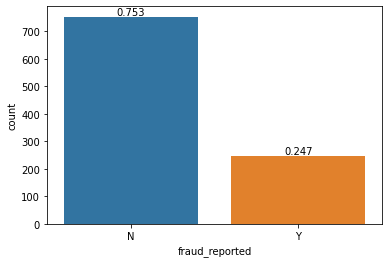

In [69]:
#build the distribution of the dependet variable
ax = sns.countplot(x=df['fraud_reported'],
                   order=df['fraud_reported'].value_counts(ascending=False).index);

abs_values = df['fraud_reported'].value_counts(ascending=False, normalize=True).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

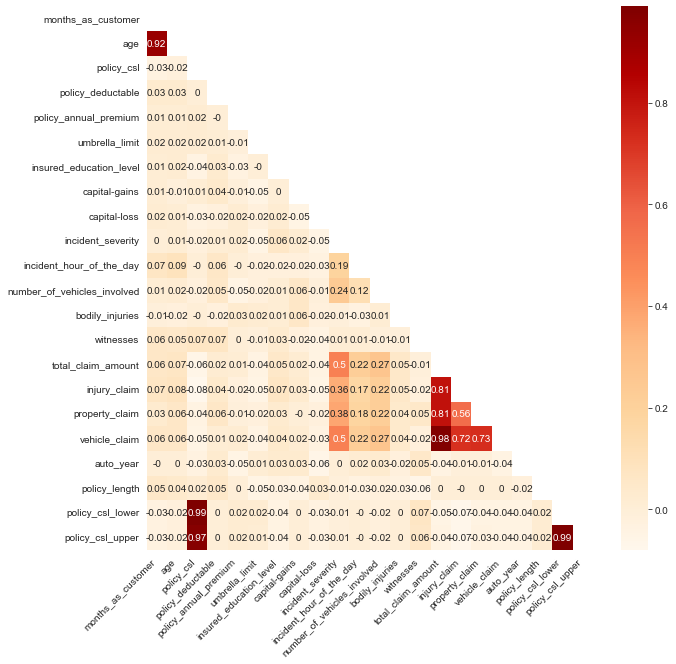

In [70]:
sns.set_style('white')

corr_list = cont_var

corr_df = df[corr_list]
corr=round(corr_df.corr(),2)

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(10,10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  #triu triangle upper

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap='OrRd')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha= 'right', rotation=45 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

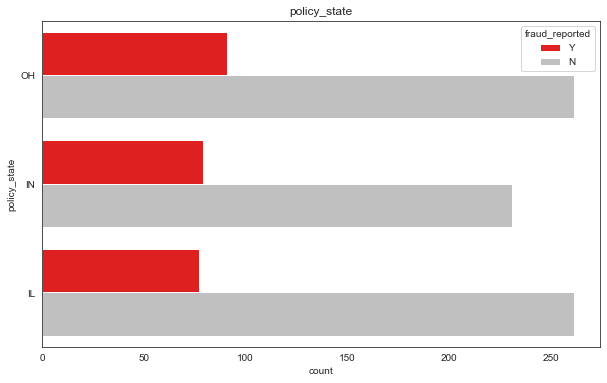

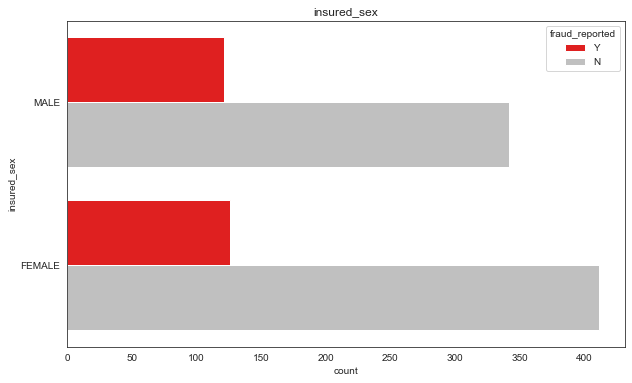

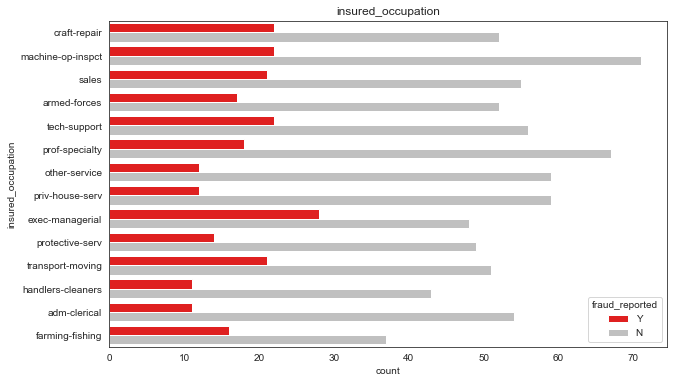

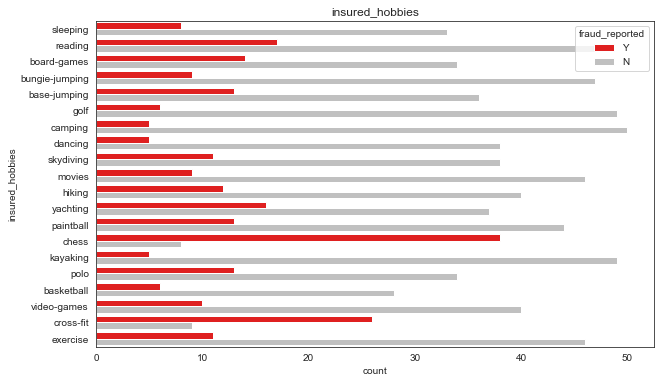

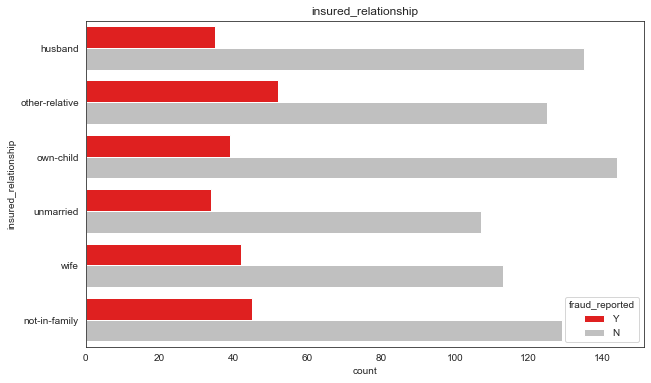

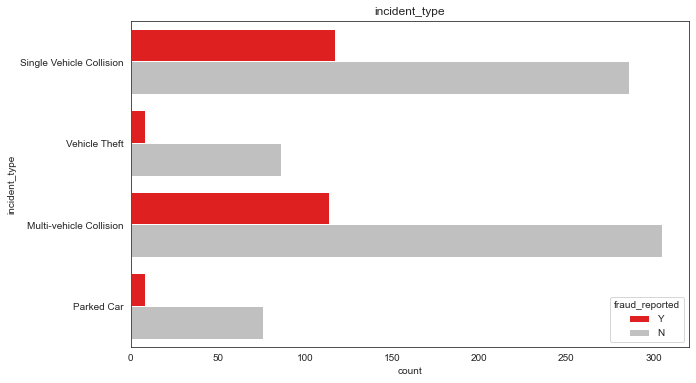

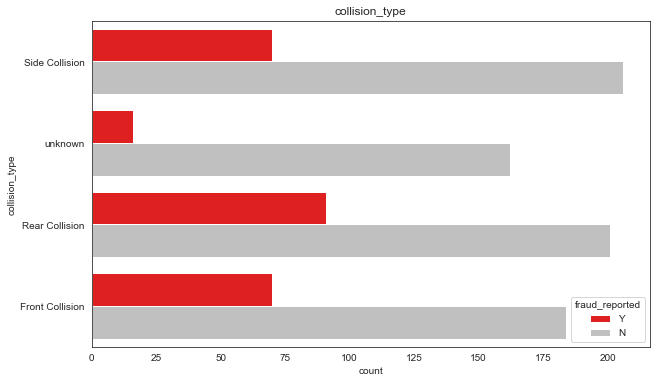

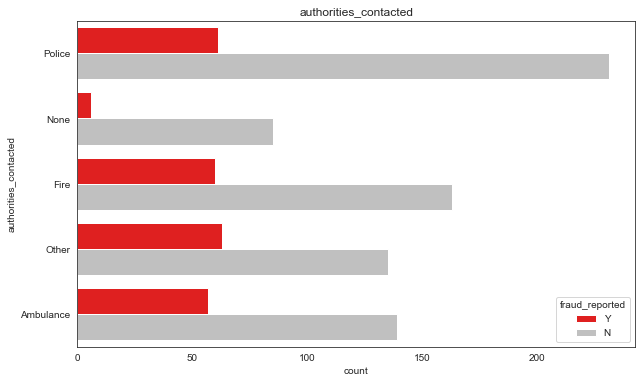

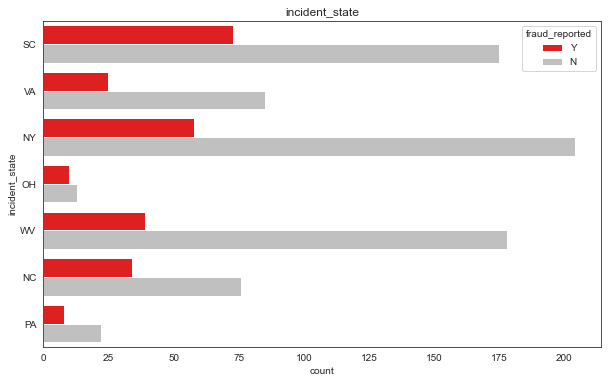

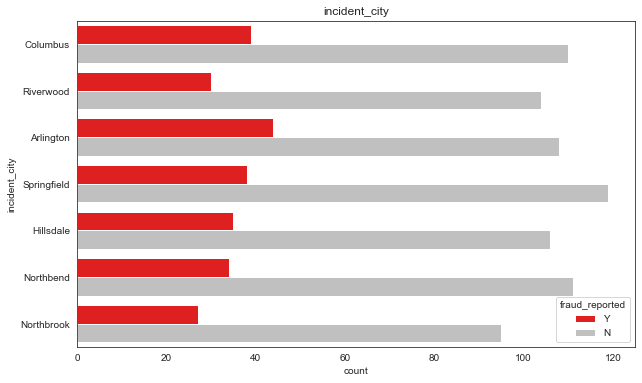

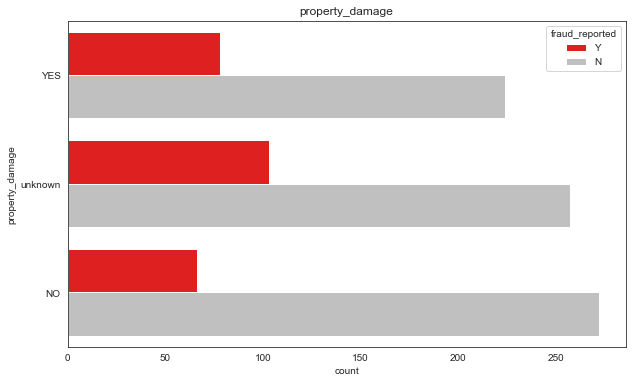

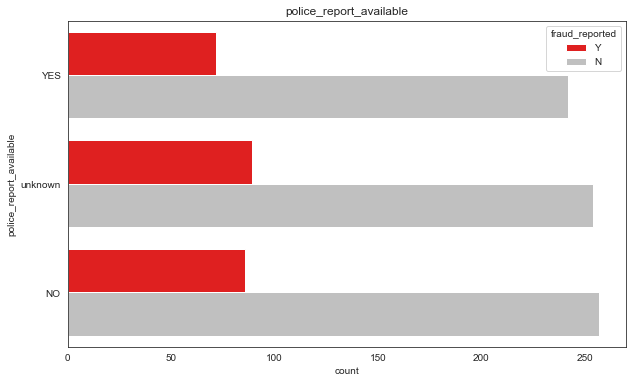

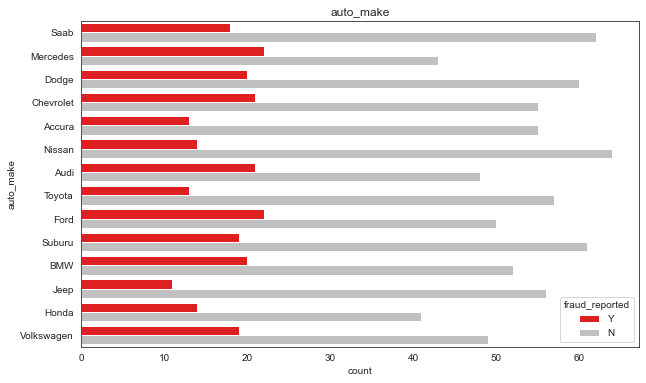

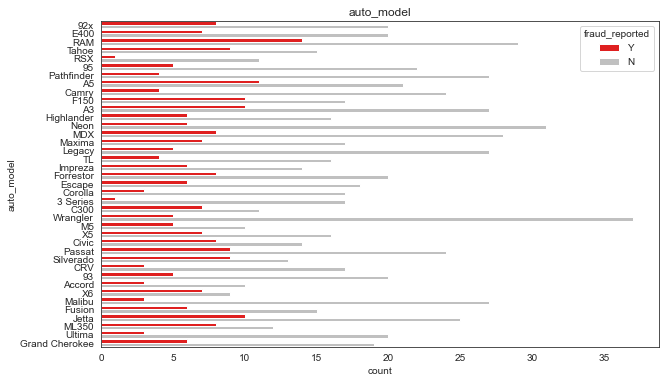

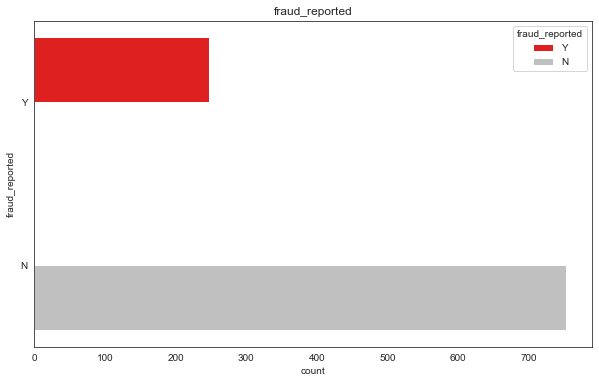

In [71]:
#countplot of discrete var , 

for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(10,6))
    sns.countplot(y=name, data=df, hue="fraud_reported", palette=['red','silver']).set(title=name)

<Figure size 1152x432 with 0 Axes>

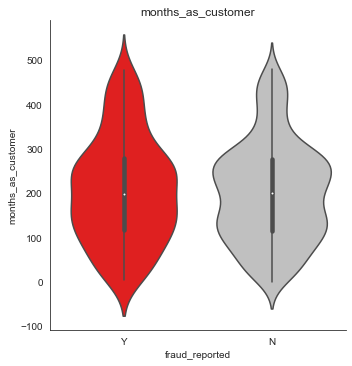

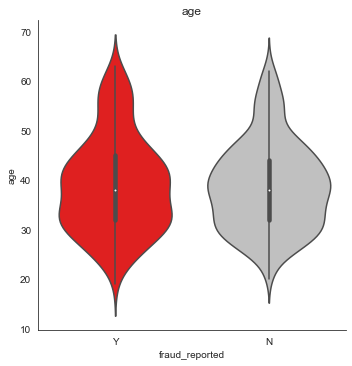

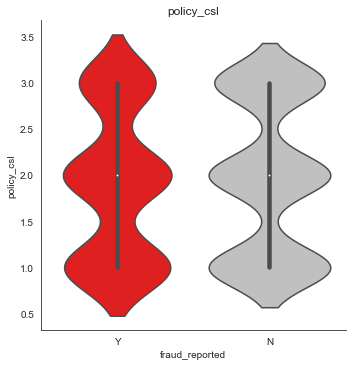

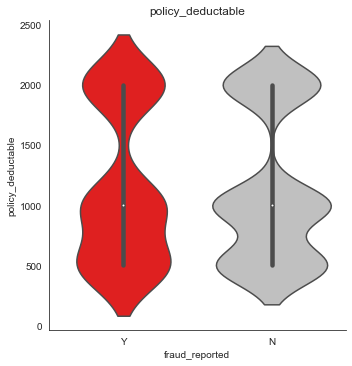

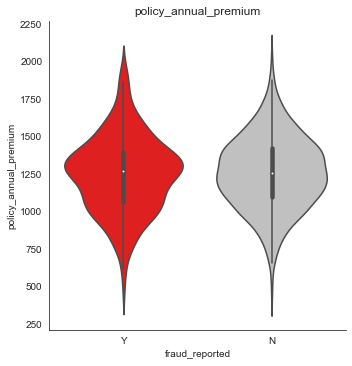

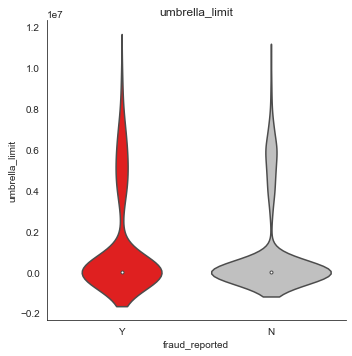

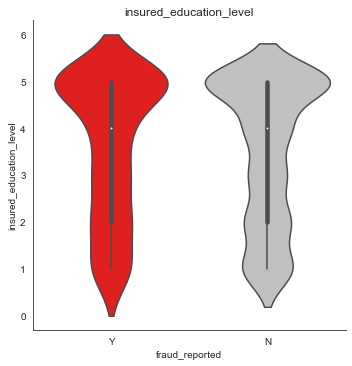

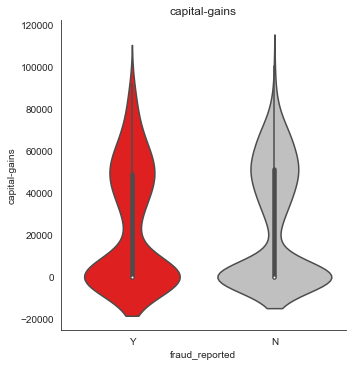

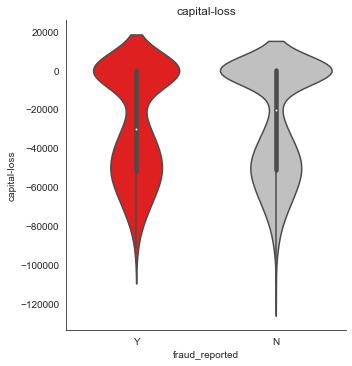

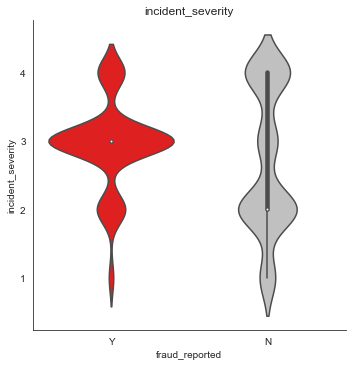

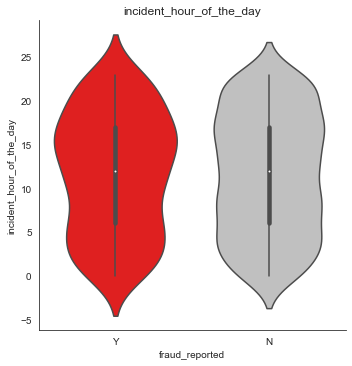

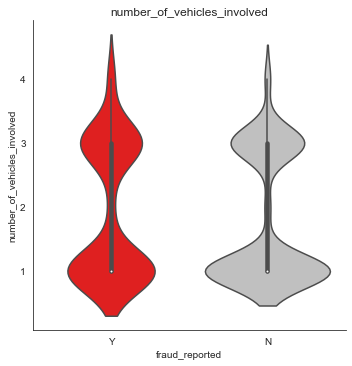

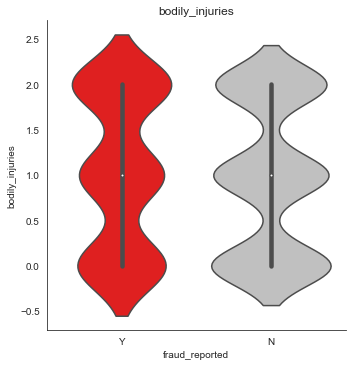

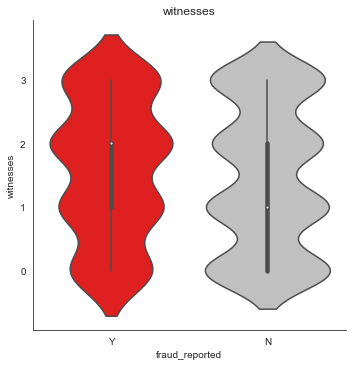

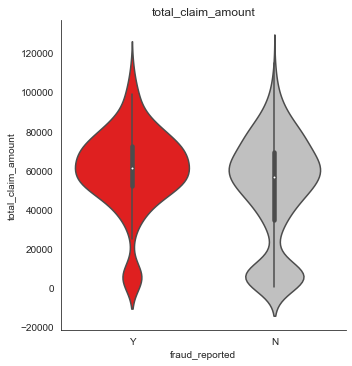

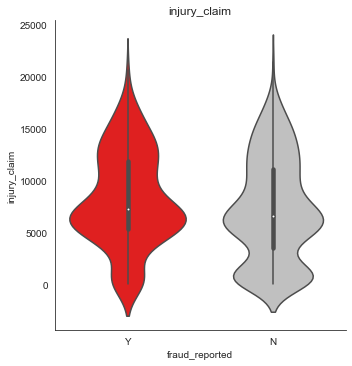

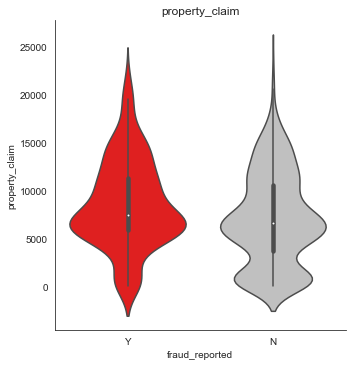

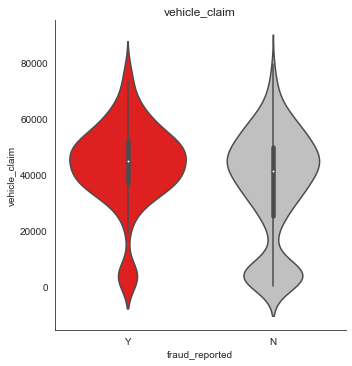

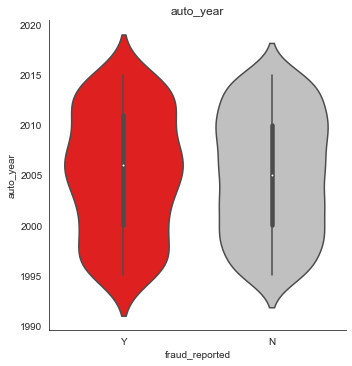

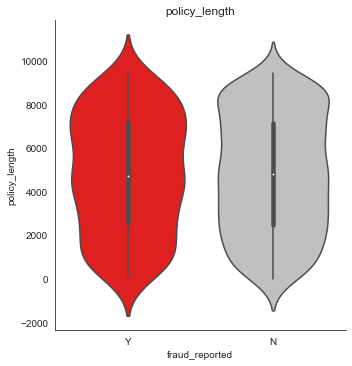

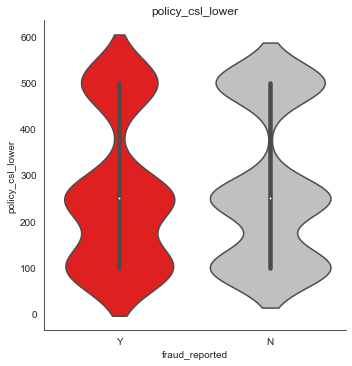

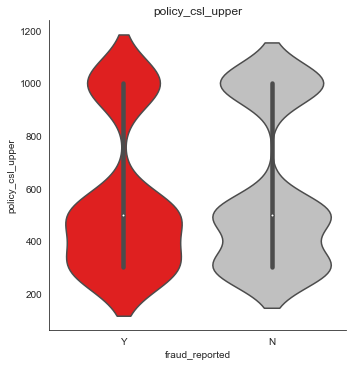

In [72]:
#each continous var and fraud reported's dist

for i, name in enumerate(df[cont_var]):
    #print(name)
    plt.figure(i,figsize=(16,6))
    sns.catplot(data=df, x="fraud_reported", y=name, kind='violin', palette=['red','silver']).set(title=name)

## Visual Analysis discussion

Upon visual overlook, there seems to be visually discerning difference between fraud and true claims from the   

Hobbies
Severity of incident
And amount claimed

Where there are no obvious patterns in the other variable, the interaction between the variables might yield better results.   We would expect in the modelling process to find more information on significant variables.

# Preprocessing
- Converted the target variable fraud_reported to 1 for Yes, and 0 for no  
- One hot encoded the categorical/nominal variables
- Scaled using MinMax Scaler all variables to between 1 and 0

In [73]:
#DV numerical code
df['fraud_reported'] = df['fraud_reported'].map({"Y":1, "N":0})

df['fraud_reported']

0      1
1      1
2      0
3      1
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: fraud_reported, Length: 1000, dtype: int64

In [74]:
# To avoid duplication, convert sex to numerical manually
df['insured_sex'] = df['insured_sex'].map({"FEMALE":0,"MALE":1})

In [75]:
# one_hot encoding
df_dum = pd.get_dummies(df)

In [76]:
#min max scaled for all variables

scaler = preprocessing.MinMaxScaler()
names = df_dum.columns

d = scaler.fit_transform(df_dum)
df_scaled = pd.DataFrame(d, columns=names)
df_scaled.head()

,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,capital-gains,capital-loss,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported,policy_length,policy_csl_lower,policy_csl_upper,policy_state_IL,policy_state_IN,policy_state_OH,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobbies_base-jumping,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,insured_hobbies_golf,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting,insured_relationship_husband,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,collision_type_unknown,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,incident_state_NC,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,incident_city_Arlington,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,property_damage_NO,property_damage_YES,property_damage_unknown,police_report_available_NO,police_report_available_YES,police_report_available_unknown,auto_make_Accura,auto_make_Audi,auto_make_BMW,auto_make_Chevrolet,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen,auto_model_3 Series,auto_model_92x,auto_model_93,auto_model_95,auto_model_A3,auto_model_A5,auto_model_Accord,auto_model_C300,auto_model_CRV,auto_model_Camry,auto_model_Civic,auto_model_Corolla,auto_model_E400,auto_model_Escape,auto_model_F150,auto_model_Forrestor,auto_model_Fusion,auto_model_Grand Cherokee,auto_model_Highlander,auto_model_Impreza,auto_model_Jetta,auto_model_Legacy,auto_model_M5,auto_model_MDX,auto_model_ML350,auto_model_Malibu,auto_model_Maxima,auto_model_Neon,auto_model_Passat,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,0.684760,0.644444,0.5,0.333333,0.603112,0.0,1.0,1.00,0.530348,1.000000,0.666667,0.217391,0.000000,0.5,0.666667,0.622801,0.303497,0.550063,0.654296,0.45,1.0,0.012704,0.375,0.285714,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [77]:
# Checking that all numbers are scaled within one
dd = df_scaled.describe()
dd.loc[['min','max']]

,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,capital-gains,capital-loss,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported,policy_length,policy_csl_lower,policy_csl_upper,policy_state_IL,policy_state_IN,policy_state_OH,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobbies_base-jumping,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,insured_hobbies_golf,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting,insured_relationship_husband,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,collision_type_unknown,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,incident_state_NC,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,incident_city_Arlington,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,property_damage_NO,property_damage_YES,property_damage_unknown,police_report_available_NO,police_report_available_YES,police_report_available_unknown,auto_make_Accura,auto_make_Audi,auto_make_BMW,auto_make_Chevrolet,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen,auto_model_3 Series,auto_model_92x,auto_model_93,auto_model_95,auto_model_A3,auto_model_A5,auto_model_Accord,auto_model_C300,auto_model_CRV,auto_model_Camry,auto_model_Civic,auto_model_Corolla,auto_model_E400,auto_model_Escape,auto_model_F150,auto_model_Forrestor,auto_model_Fusion,auto_model_Grand Cherokee,auto_model_Highlander,auto_model_Impreza,auto_model_Jetta,auto_model_Legacy,auto_model_M5,auto_model_MDX,auto_model_ML350,auto_model_Malibu,auto_model_Maxima,auto_model_Neon,auto_model_Passat,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

# Exploratory Modelling

## 1. Baseline setting

Going through 4 types of models

1. Regression
2. Distance based KNN
3. Probability based NB
4. Decision tree based Random Forest

We identified that the decision tree based Random forrest performed best in term of Area under the ROC curve (AUC) score.

However looking in positive identification recall, the probablility based model performed with a similar score.

We do know, however from the previous data exploration that the data is imbalanced.   This is what is causing the large discrepency between the prevision and recall performance.   We need to balance the training sample to create a better model

In [78]:
#separating the target variable from the model

x = df_scaled.drop('fraud_reported', axis=1)
y = df_scaled['fraud_reported']

In [79]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=888)

### Regression Modelling

In [80]:
#ransearch log reg

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            'class_weight':[{0:0.246667, 1:0.75333},None]}

    
rs_lr = RandomizedSearchCV(lr, lr_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)
rs_lr.fit(x_train, y_train)
print(rs_lr.best_params_)

{'solver': 'liblinear', 'penalty': 'l2', 'class_weight': {0: 0.246667, 1: 0.75333}, 'C': 0.7906043210907702}


              precision    recall  f1-score   support

         0.0       0.85      0.73      0.79       188
         1.0       0.43      0.61      0.51        62

    accuracy                           0.70       250
   macro avg       0.64      0.67      0.65       250
weighted avg       0.75      0.70      0.72       250

ROC-AUC score is: 0.723


alt.LayerChart(...)

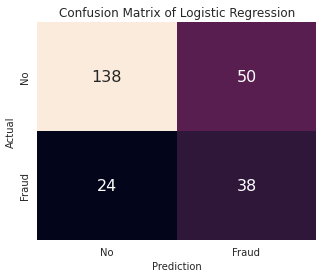

In [81]:
classification_report, cmplot, roc_curve, roc_score = scores('Logistic Regression', rs_lr, x_test, y_test )
roc_curve

In [82]:
evaluation = []
x = ['Logistic Regression', roc_score]
evaluation.append(x)

### Distance based model - KNN

In [83]:
# KNN

knn = KNeighborsClassifier()
ss = StandardScaler()

knn_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))])

knn_values = {'knn__n_neighbors':[3,5,7,9,11],
              'knn__weights':['uniform', 'distance'],
              'knn__metric':['minkowski','euclidean','manhattan'],
              'knn__algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size':[1,2,3,4,5,6,7,8,9,10]
             }

    
rs_knn = RandomizedSearchCV(knn_pipe, knn_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)
rs_knn.fit(x_train, y_train)
print(rs_knn.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': 11, 'knn__metric': 'manhattan', 'knn__leaf_size': 8, 'knn__algorithm': 'brute'}


              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86       188
         1.0       0.60      0.05      0.09        62

    accuracy                           0.76       250
   macro avg       0.68      0.52      0.47       250
weighted avg       0.72      0.76      0.67       250

ROC-AUC score is: 0.6141


alt.LayerChart(...)

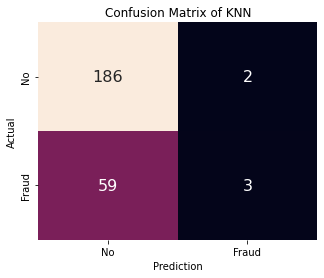

In [84]:
classification_report, cmplot, roc_curve, roc_score = scores('KNN', rs_knn, x_test, y_test )
roc_curve

In [85]:
x = ['KNN', roc_score]
evaluation.append(x)

### Probability Based - Naive Bayes

In [86]:
nb = GaussianNB()

#define pipeline for selector
nb_values = {'var_smoothing': np.logspace(0,-9, num=100)}

nb_rf = RandomizedSearchCV(nb, nb_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)

nb_rf.fit(x_train, y_train)

print(nb_rf.best_params_)

{'var_smoothing': 0.04328761281083057}


              precision    recall  f1-score   support

         0.0       0.85      0.66      0.75       188
         1.0       0.39      0.65      0.48        62

    accuracy                           0.66       250
   macro avg       0.62      0.66      0.62       250
weighted avg       0.74      0.66      0.68       250

ROC-AUC score is: 0.7418


alt.LayerChart(...)

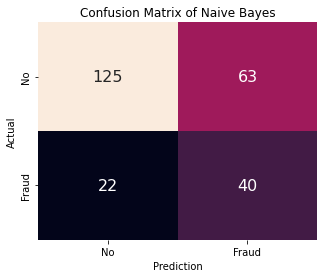

In [87]:
classification_report, cmplot, roc_curve, roc_score = scores('Naive Bayes', nb_rf, x_test, y_test )
roc_curve

In [88]:
x = ['Naive Bayes', roc_score]
evaluation.append(x)

### Tree Based - Random Forest

In [89]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'class_weight':[{0:0.246667, 1:0.75333},None]
              }


    
rs_rf = RandomizedSearchCV(rf, rf_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)
rs_rf.fit(x_train, y_train)
print(rs_rf.best_params_)

{'n_estimators': 600, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'class_weight': None}


              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86       188
         1.0       0.50      0.02      0.03        62

    accuracy                           0.75       250
   macro avg       0.63      0.51      0.44       250
weighted avg       0.69      0.75      0.65       250

ROC-AUC score is: 0.8532


alt.LayerChart(...)

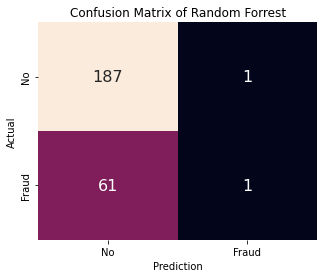

In [90]:
classification_report, cmplot, roc_curve, roc_score = scores('Random Forrest', rs_rf, x_test, y_test )
roc_curve

In [91]:
x = ['Random Forrest', roc_score]
evaluation.append(x)

## 2. Oversampling using SMOTE



1.0    565
0.0    565
Name: fraud_reported, dtype: int64


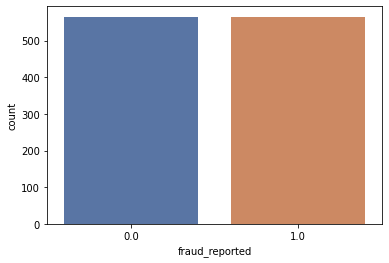

In [92]:
#SMOTE data for train set

oversample = SMOTE()
x_train_smote, y_train_smote = oversample.fit_resample(x_train, y_train)
print(y_train_smote.value_counts())

sns.countplot(x=y_train_smote, palette='deep');

### Logistic Regression

In [93]:
#ransearch log reg

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            'class_weight':[{0:0.246667, 1:0.75333},None]}

    
rs_lr2 = RandomizedSearchCV(lr, lr_values, cv=10, scoring='f1', n_jobs = -1, random_state=888)
rs_lr2.fit(x_train_smote, y_train_smote)
print(rs_lr2.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'class_weight': {0: 0.246667, 1: 0.75333}, 'C': 13.257113655901108}


              precision    recall  f1-score   support

         0.0       0.86      0.60      0.71       188
         1.0       0.37      0.71      0.49        62

    accuracy                           0.63       250
   macro avg       0.62      0.66      0.60       250
weighted avg       0.74      0.63      0.65       250

ROC-AUC score is: 0.7059


alt.LayerChart(...)

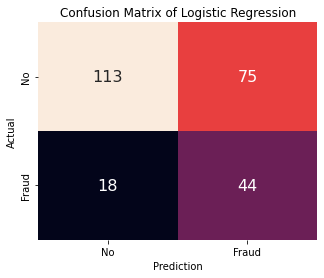

In [94]:
classification_report, cmplot, roc_curve, roc_score = scores('Logistic Regression', rs_lr2, x_test, y_test )
roc_curve

In [95]:
x = ['Logistic Regression SMOTE', roc_score]
evaluation.append(x)

### KNN

In [96]:
# KNN

knn = KNeighborsClassifier()
ss = StandardScaler()

knn_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))])

knn_values = {'knn__n_neighbors':[3,5,7,9,11],
              'knn__weights':['uniform', 'distance'],
              'knn__metric':['minkowski','euclidean','manhattan'],
              'knn__algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size':[1,2,3,4,5,6,7,8,9,10]
             }

    
rs_knn2 = RandomizedSearchCV(knn_pipe, knn_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)
rs_knn2.fit(x_train_smote, y_train_smote)
print(rs_knn2.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'manhattan', 'knn__leaf_size': 8, 'knn__algorithm': 'brute'}


              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       188
         1.0       0.29      0.39      0.33        62

    accuracy                           0.61       250
   macro avg       0.53      0.53      0.53       250
weighted avg       0.65      0.61      0.63       250

ROC-AUC score is: 0.5607


alt.LayerChart(...)

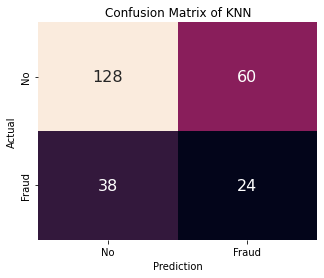

In [97]:
classification_report, cmplot, roc_curve, roc_score = scores('KNN', rs_knn2, x_test, y_test )
roc_curve

In [98]:
x = ['KNN SMOTE', roc_score]
evaluation.append(x)

### Naive Bayes

In [99]:
nb = GaussianNB()

#define pipeline for selector
nb_values = {'var_smoothing': np.logspace(0,-9, num=100)}

nb_rf2 = RandomizedSearchCV(nb, nb_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)

nb_rf2.fit(x_train_smote, y_train_smote)

print(nb_rf2.best_params_)

{'var_smoothing': 0.04328761281083057}


              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74       188
         1.0       0.39      0.68      0.49        62

    accuracy                           0.66       250
   macro avg       0.62      0.66      0.62       250
weighted avg       0.74      0.66      0.68       250

ROC-AUC score is: 0.7371


alt.LayerChart(...)

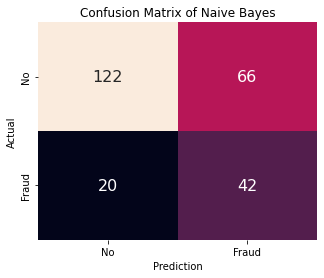

In [100]:
classification_report, cmplot, roc_curve, roc_score = scores('Naive Bayes', nb_rf2, x_test, y_test )
roc_curve

In [101]:
x = ['Naive Bayes SMOTE', roc_score]
evaluation.append(x)

### Random Forrest

In [102]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'class_weight':[{0:0.246667, 1:0.75333},None]
              }


    
rs_rf2 = RandomizedSearchCV(rf, rf_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)
rs_rf2.fit(x_train_smote, y_train_smote)
print(rs_rf2.best_params_)

{'n_estimators': 600, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'class_weight': None}


              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87       188
         1.0       0.69      0.15      0.24        62

    accuracy                           0.77       250
   macro avg       0.73      0.56      0.55       250
weighted avg       0.76      0.77      0.71       250

ROC-AUC score is: 0.8567


alt.LayerChart(...)

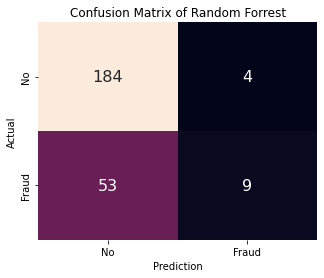

In [103]:
classification_report, cmplot, roc_curve, roc_score = scores('Random Forrest', rs_rf2, x_test, y_test )
roc_curve

In [104]:
x = ['Random Forrest SMOTE', roc_score]
evaluation.append(x)

## 3.  Modeling with Oversampling using ADASYN


ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data, and its greatest advantages are not copying the same minority data, and generating more data for “harder to learn” examples.
ADASYN does is same as SMOTE just with a minor improvement. After creating those sample, it adds a random small value to the points thus making it more realistic.

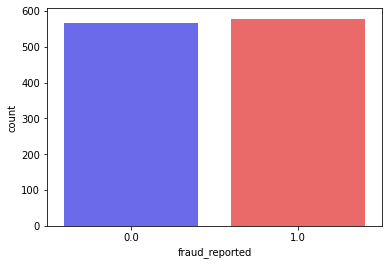

In [109]:
#adasyn data for train set

oversample = ADASYN()
x_train_adasyn, y_train_adasyn = oversample.fit_resample(x_train, y_train)
sns.countplot(x=y_train_adasyn, palette='seismic');

### Logistic Regression

In [110]:
#ransearch log reg

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            'class_weight':[{0:0.246667, 1:0.75333},None]}

    
rs_lr3 = RandomizedSearchCV(lr, lr_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)
rs_lr3.fit(x_train_adasyn, y_train_adasyn )
print(rs_lr3.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 54.286754393238596}


              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77       188
         1.0       0.39      0.55      0.46        62

    accuracy                           0.68       250
   macro avg       0.61      0.63      0.61       250
weighted avg       0.72      0.68      0.69       250

ROC-AUC score is: 0.699


alt.LayerChart(...)

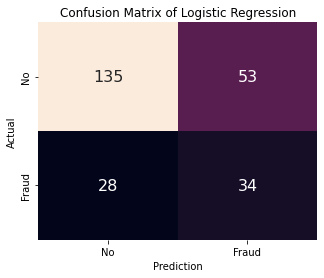

In [111]:
classification_report, cmplot, roc_curve, roc_score = scores('Logistic Regression', rs_lr3, x_test, y_test )
roc_curve

In [112]:
x = ['Logistic Regression ADASYN', roc_score]
evaluation.append(x)

### KNN

In [113]:
# KNN

knn = KNeighborsClassifier()
ss = StandardScaler()

knn_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))])

knn_values = {'knn__n_neighbors':[3,5,7,9,11],
              'knn__weights':['uniform', 'distance'],
              'knn__metric':['minkowski','euclidean','manhattan'],
              'knn__algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size':[1,2,3,4,5,6,7,8,9,10]
             }

    
rs_knn3 = RandomizedSearchCV(knn_pipe, knn_values, scoring='roc_auc', cv=10, n_jobs = -1, random_state=888)
rs_knn3.fit(x_train_adasyn, y_train_adasyn )
print(rs_knn3.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'manhattan', 'knn__leaf_size': 8, 'knn__algorithm': 'brute'}


              precision    recall  f1-score   support

         0.0       0.78      0.66      0.71       188
         1.0       0.30      0.44      0.35        62

    accuracy                           0.60       250
   macro avg       0.54      0.55      0.53       250
weighted avg       0.66      0.60      0.62       250

ROC-AUC score is: 0.5598


alt.LayerChart(...)

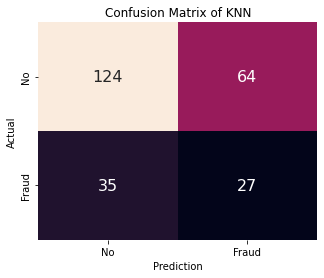

In [114]:
classification_report, cmplot, roc_curve, roc_score = scores('KNN', rs_knn3, x_test, y_test )
roc_curve

In [115]:
x = ['KNN ADASYN', roc_score]
evaluation.append(x)

### Naive Bayes

In [116]:
nb = GaussianNB()

#define pipeline for selector
nb_values = {'var_smoothing': np.logspace(0,-9, num=100)}

nb_rf3 = RandomizedSearchCV(nb, nb_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)

nb_rf3.fit(x_train_adasyn, y_train_adasyn )

print(nb_rf3.best_params_)

{'var_smoothing': 0.04328761281083057}


              precision    recall  f1-score   support

         0.0       0.87      0.64      0.74       188
         1.0       0.40      0.71      0.51        62

    accuracy                           0.66       250
   macro avg       0.63      0.68      0.62       250
weighted avg       0.75      0.66      0.68       250

ROC-AUC score is: 0.7379


alt.LayerChart(...)

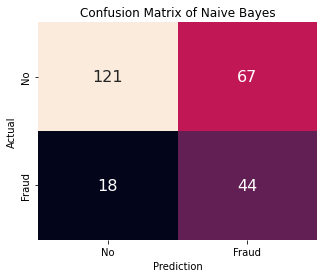

In [117]:
classification_report, cmplot, roc_curve, roc_score = scores('Naive Bayes', nb_rf3, x_test, y_test )
roc_curve

In [118]:
x = ['Naive Bayes ADASYN', roc_score]
evaluation.append(x)

### Random Forest

In [119]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'class_weight':[{0:0.246667, 1:0.75333},None]
              }


    
rs_rf3 = RandomizedSearchCV(rf, rf_values, cv=10, scoring='roc_auc', n_jobs = -1, random_state=888)
rs_rf3.fit(x_train_adasyn, y_train_adasyn )
print(rs_rf3.best_params_)

{'n_estimators': 600, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'class_weight': None}


              precision    recall  f1-score   support

         0.0       0.79      0.98      0.87       188
         1.0       0.76      0.21      0.33        62

    accuracy                           0.79       250
   macro avg       0.78      0.59      0.60       250
weighted avg       0.78      0.79      0.74       250

ROC-AUC score is: 0.8727


alt.LayerChart(...)

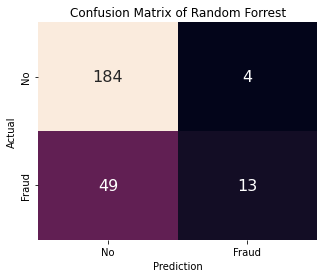

In [120]:
classification_report, cmplot, roc_curve, roc_score = scores('Random Forrest', rs_rf3, x_test, y_test )
roc_curve

In [121]:
x = ['Random Forrest ADASYN', roc_score]
evaluation.append(x)

In [123]:
evaluationLog = pd.DataFrame(evaluation, columns = ['Model', 'roc_auc score'])

In [124]:
evaluationLog

,Model,roc_auc score
0,Logistic Regression,0.722975
1,KNN,0.614061
2,Naive Bayes,0.741850
3,Random Forrest,0.853209
4,Logistic Regression SMOTE,0.705903
5,KNN SMOTE,0.560655
6,Naive Bayes SMOTE,0.737131
7,Random Forrest SMOTE,0.856726
8,Logistic Regression ADASYN,0.699039
9,KNN ADASYN,0.559840


In [125]:
evaluationLog.to_csv('Evaluation Log.csv')